In [1]:
import numpy as np 
import pandas as pd 
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use("ggplot")
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Preprocessing

In [2]:
data = pd.read_excel('/kaggle/input/basket-analysis/Basket Analysis - Data.xlsx')
data.head()

,Transaction Date,Customer ID,Product Description
0,2014-01-01,1249,citrus fruit
1,2014-01-01,1249,coffee
2,2014-01-01,1249,italian sausage
3,2014-01-01,1249,sausage
4,2014-01-01,1381,curd


In [3]:
data["Customer ID"].nunique(),data["Customer ID"].unique()

(3898, array([1249, 1381, 1440, ..., 4755, 1963, 4565]))

In [4]:
data["Product Description"].nunique()

170

In [5]:
ID=data["Customer ID"].unique()
ID.tolist()
ID.sort()

In [6]:
item=data.groupby('Customer ID')['Product Description'].apply(list)
items=[]
for i in range(3898):
    items.append(item.iloc[i])
basket=pd.DataFrame({"item":ID,"products":items})
basket['products'] = basket['products'].astype(str)
regex = r'[\[\]/,]'
basket['products'] = basket['products'].apply(lambda x: re.sub(regex, '', x))
basket.head(2)

,item,products
0,1000,'pastry' 'salty snack' 'small milk' 'med milk'...
1,1001,'rollsbuns' 'sausage' 'small milk' 'med milk' ...


In [7]:
#concatenate multi-word product names together
basket['products'] = basket['products'].apply(lambda x: re.sub(r'(\w+)\s(\w+)', r'\1_\2', x))
basket

,item,products
0,1000,'pastry' 'salty_snack' 'small_milk' 'med_milk'...
1,1001,'rollsbuns' 'sausage' 'small_milk' 'med_milk' ...
2,1002,'frozen_vegetables' 'other_vegetables' 'butter...
3,1003,'dental_care' 'frozen_meals' 'sauces' 'rollsbu...
4,1004,'med_milk' 'pip_fruit' 'tropical_fruit' 'cling...
...,...,...
3893,4996,'salty_snack' 'tropical_fruit' 'bottled_beer' ...
3894,4997,'canned_beer' 'italian_sausage' 'large_milk' '...
3895,4998,'curd' 'rollsbuns'
3896,4999,'herbs' 'newspapers' 'semi-finished_bread' 'de...


In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(data):
    preprocessed_data = []
    for products in data:
        products = products.split()
        products = [lemmatizer.lemmatize(p) for p in products if p not in stop_words]
        preprocessed_data.append(" ".join(products))
    return preprocessed_data
    
basket['products'] = preprocess(basket['products'])


****

# Modeling

In [21]:
pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 327.9 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=b469cd6f0fece556ae15d567e136f5c427bf36c191783944fb2b63bb16c659f9
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
Note: you may need to restart the kernel to use updated packages.


In [23]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(basket['products'])

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/122 [00:00<?, ?it/s]

In [24]:
embeddings.shape

(3898, 384)

In [34]:
# Normalize the embeddings to unit length
embeddings = embeddings /  np.linalg.norm(embeddings, axis=1, keepdims=True)

# Perform kmean clustering
clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=3.5) #, affinity='cosine', linkage='average', distance_threshold=0.4)
cluster_labels = clustering_model.fit_predict(embeddings)
# Print the products in each cluster
# for i in range(clustering_model.n_clusters_):
#     print("Cluster", i+1)
#     cluster_indices = np.where(cluster_labels == i)[0]
#     for index in cluster_indices:
#         print(basket.iloc[index]['products'])


Cluster 1
'rollsbuns' 'margarine' 'whippedsour_cream'
'hamburger_meat' 'large_milk' 'redblush_wine' 'shopping_bags'
'med_milk' 'pastry' 'bottled_water' 'pork' 'salad_dressing'
'med_milk' 'tropical_fruit' 'hamburger_meat' 'pork' 'chocolate' 'coffee' 'rollsbuns' 'tropical_fruit'
'soda' 'yogurt' 'pork' 'spread_cheese'
'grapes' 'large_milk'
'curd' 'soft_cheese' 'berries' 'pastry' 'pip_fruit'
'beef' 'curd' 'frozen_meals' 'rollsbuns' 'soda' 'large_milk' 'napkins' 'tropical_fruit' 'UHT-milk'
'whippedsour_cream' 'yogurt'
'liqueur' 'pastry' 'baking_powder' 'herbs' 'processed_cheese' 'sausage' 'specialty_cheese'
'butter' 'cereals' 'med_milk'
'med_milk' 'oil' 'beverages' 'pork'
'chicken' 'yogurt'
'other_vegetables' 'whippedsour_cream'
'canned_beer' 'ice_cream'
'curd' 'meat' 'canned_beer' 'small_milk' 'UHT-milk'
'beef' 'med_milk' 'soft_cheese' 'yogurt'
'soft_cheese' 'UHT-milk' 'hamburger_meat' 'italian_sausage' 'med_milk' 'yogurt'
'berries' 'soda' 'pork' 'sugar' 'pork' 'soda'
'UHT-milk' 'whippedso

In [36]:
np.unique(cluster_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [30]:
clusters = {}
for cluster_id in set(clustering_model.labels_):
    cluster_products = basket['products'][clustering_model.labels_ == cluster_id]
    clusters[cluster_id] = pd.DataFrame({'products': cluster_products})

# Print the products in each cluster
for cluster_id, df in clusters.items():
    print("Cluster {}:".format(cluster_id))
    print(df)

Cluster 0:
                                               products
5           'rollsbuns' 'margarine' 'whippedsour_cream'
18    'hamburger_meat' 'large_milk' 'redblush_wine' ...
44    'med_milk' 'pastry' 'bottled_water' 'pork' 'sa...
64    'med_milk' 'tropical_fruit' 'hamburger_meat' '...
65               'soda' 'yogurt' 'pork' 'spread_cheese'
...                                                 ...
3802  'chicken' 'fruitvegetable_juice' 'curd' 'hard_...
3806  'bottled_beer' 'rollsbuns' 'whippedsour_cream'...
3825                  'beef' 'cake_bar' 'spread_cheese'
3858                                 'candy' 'med_milk'
3879                    'butter' 'canned_beer' 'pastry'

[172 rows x 1 columns]
Cluster 1:
                                               products
3     'dental_care' 'frozen_meals' 'sauces' 'rollsbu...
32    'cat_food' 'cling_filmbags' 'pip_fruit' 'yogur...
57    'dessert' 'other_vegetables' 'root_vegetables'...
89                            'dessert' 'domestic_eggs'
10

In [41]:

# # Calculate pairwise distances
# distance_matrix = pairwise_distances(embeddings)

# # Print the top 10 nearest products for each product
# for i in range(distance_matrix.shape[0]):
#     nearest_indices = np.argsort(distance_matrix[i])[:10]
#     print("Top 10 nearest products for product", i+1)
#     for index in nearest_indices:
#         print(basket.iloc[index]['products'])


In [9]:
def jaccard_similarity(matrix):
    # Compute the Jaccard similarity between all pairs of products
    n_products = matrix.shape[1]
    jaccard_similarities = np.zeros((n_products, n_products))
    for i in range(n_products):
        for j in range(i, n_products):
            intersection = np.sum(matrix[:, i] & matrix[:, j])
            union = np.sum(matrix[:, i] | matrix[:, j])
            jaccard_similarities[i, j] = intersection / union
            jaccard_similarities[j, i] = jaccard_similarities[i, j]
    return jaccard_similarities

In [10]:
# Vectorize the data
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(basket['products']).toarray()
features = tfidf.get_feature_names_out()
tfidf_data = pd.DataFrame(tfidf_matrix, columns=features)
# Convert the tf-idf matrix to a binary matrix
binary_matrix = tfidf_matrix > 0
# Compute the Jaccard similarity between products
products_similarities = jaccard_similarity(binary_matrix)

from sklearn.cluster import AgglomerativeClustering
# n_clusters = 2

# Perform Hierarchical Clustering
agg =AgglomerativeClustering(n_clusters=None, distance_threshold=2.1)
agg.fit(products_similarities)

unique_labels = np.unique(agg.labels_)
print(len(unique_labels), "\n")

silhouette_avg =silhouette_score(tfidf_matrix.T, agg.labels_)
print("For n_clusters =", len(unique_labels), "The average silhouette_score is :", silhouette_avg,"\n\n")


# for i in unique_labels:
#     indices = np.where(agg.labels_ == i)[0]
#     print("Cluster {}: {}".format(i+1, ', '.join(np.array(tfidf.get_feature_names())[indices].tolist())))
#     print("\n\n")

9 

For n_clusters = 9 The average silhouette_score is : -0.17708387221006858 




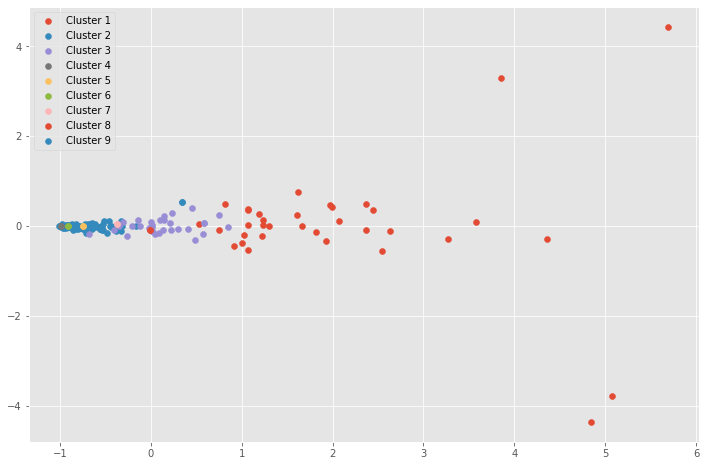

In [11]:
# Reduce the dimensionality of the data to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.T)

# Plot the results
plt.figure(figsize=(12,8))

for i in unique_labels:
    indices = np.where(agg.labels_ == i)[0]
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'Cluster {i+1}')
#     for j, product in enumerate(np.array(tfidf.get_feature_names())[indices.tolist()]):
#         plt.annotate(product, (pca_result[indices, 0][j], pca_result[indices, 1][j]))
plt.legend()
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


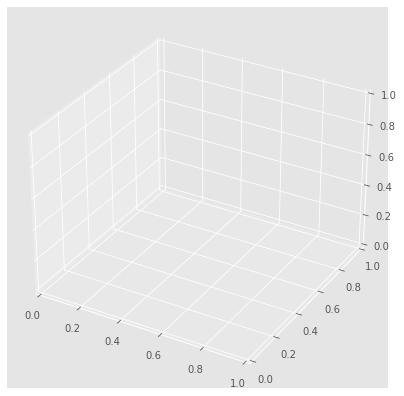

In [12]:
import plotly.colors
import plotly.graph_objs as go
# Reduce the dimensionality of the data to 2D
pca = PCA(n_components=3)
pca_result = pca.fit_transform(tfidf_matrix.T)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111, projection='3d')
offset = 0.1
data = []
for i in unique_labels:
    indices = np.where(agg.labels_ == i)[0]
    trace = go.Scatter3d(x=pca_result[indices, 0], y=pca_result[indices, 1], z=pca_result[indices, 2], mode='markers',
    marker=dict(size=10, color=plotly.colors.DEFAULT_PLOTLY_COLORS[i]),
    text=[tfidf.get_feature_names()[i] for i in indices],
    name=f'Cluster {i+1}')
    data.append(trace)


layout = go.Layout(title='3D Plot',scene=dict(xaxis=dict(title='PC1'), yaxis=dict(title='PC2'), zaxis=dict(title='PC3')))
fig = go.Figure(data=data, layout=layout)
fig.show()

****

In [13]:
df_transposed = tfidf_data.transpose()
df_transposed.head(5)

,0,1,2,3,4,5,6,7,8,9,...,3888,3889,3890,3891,3892,3893,3894,3895,3896,3897
abrasive_cleaner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.484943,0.0,0.0,0.0,0.0,0.0,0.0,0.0
appetizer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.393053,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
artif,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
baby_cosmetics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bags,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
from sklearn.metrics import pairwise_distances
# Perform k-means clustering
n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters,random_state=0)
kmeans.fit(df_transposed)

# Get the cluster assignments for each product
clusters = kmeans.predict(df_transposed)

# Add the cluster assignments as a new column in the dataframe
# df_transposed["cluster"] = clusters

# Compute the similarity between products
products_similarities = 1 - pairwise_distances(df_transposed, metric="cosine")

unique_labels = np.unique(clusters)
print(len(unique_labels), "\n")

silhouette_avg =silhouette_score(df_transposed, clusters)
print("For n_clusters =", len(unique_labels), "The average silhouette_score is :", silhouette_avg,"\n\n")

# Print the products in each cluster
for i in range(n_clusters):
    indices = np.where(kmeans.labels_ == i)[0]
    print("Cluster {}: {}".format(i+1, ', '.join(df_transposed.index[indices].tolist())))
    print("\n\n")



9 

For n_clusters = 9 The average silhouette_score is : 0.24142291017007814 


Cluster 1: abrasive_cleaner, appetizer, artif, baby_cosmetics, bags, bakery_product, baking_powder, bathroom_cleaner, berries, beverages, bottled_beer, bottled_water, brandy, brown_bread, butter, butter_milk, cake_bar, candles, candy, canned_beer, canned_fish, canned_fruit, canned_vegetables, cat_food, cereals, chewing_gum, chicken, chocolate, chocolate_marshmallow, citrus_fruit, cleaner, cling_filmbags, cocoa_drinks, coffee, condensed_milk, cooking_chocolate, cookware, cream, cream_cheese, curd, curd_cheese, decalcifier, delete, dental_care, dessert, detergent, dish_cleaner, dishes, dog_food, domestic_eggs, female_sanitary, finished_bread, finished_products, fish, flour, flower, flower_soilfertilizer, frozen_chicken, frozen_dessert, frozen_fish, frozen_fruits, frozen_meals, frozen_potato, frozen_vegetables, fruitvegetable_juice, grapes, hair_spray, ham, hamburger_meat, hard_cheese, herbs, honey, house_keep

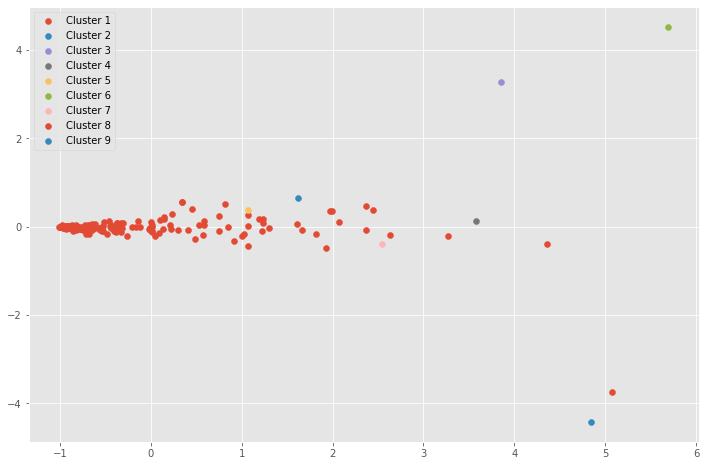

In [15]:
# Reduce the dimensionality of the data to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_transposed)

# Plot the results
plt.figure(figsize=(12,8))
for i in range(n_clusters):
    indices = np.where(kmeans.labels_ == i)[0]
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'Cluster {i+1}')
#     for j, product in enumerate(np.array(tfidf.get_feature_names())[indices.tolist()]):
#         plt.annotate(product, (pca_result[indices, 0][j], pca_result[indices, 1][j]))
plt.legend()
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



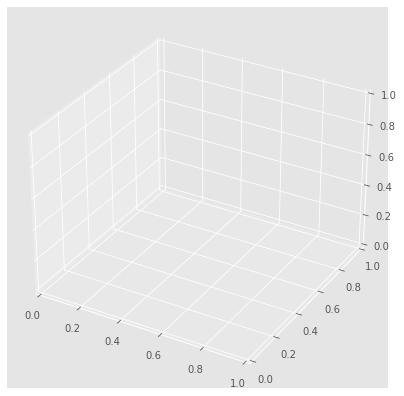

In [16]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_transposed)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111, projection='3d')
offset = 0.1
data = []
for i in unique_labels:
    indices = np.where(kmeans.labels_ == i)[0]
    trace = go.Scatter3d(x=pca_result[indices, 0], y=pca_result[indices, 1], z=pca_result[indices, 2], mode='markers',
    marker=dict(size=10, color=plotly.colors.DEFAULT_PLOTLY_COLORS[i]),
    text=[tfidf.get_feature_names()[i] for i in indices],
    name=f'Cluster {i+1}')
    data.append(trace)


layout = go.Layout(title='3D Plot',scene=dict(xaxis=dict(title='PC1'), yaxis=dict(title='PC2'), zaxis=dict(title='PC3')))
fig = go.Figure(data=data, layout=layout)
fig.show()

# XAI

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
kmeanModel = KMeans(n_clusters=9)
y=kmeanModel.fit(df_transposed).labels_
y = label_binarize(y, classes=[0,1,2,3,4,5,6,7,8])
clf=RandomForestClassifier()
clf.fit(df_transposed,y)

RandomForestClassifier()

In [18]:
import shap
explainer= shap.TreeExplainer(clf)
shap_values = explainer(df_transposed).values

In [19]:
shap_values.shape

(177, 3898, 18)

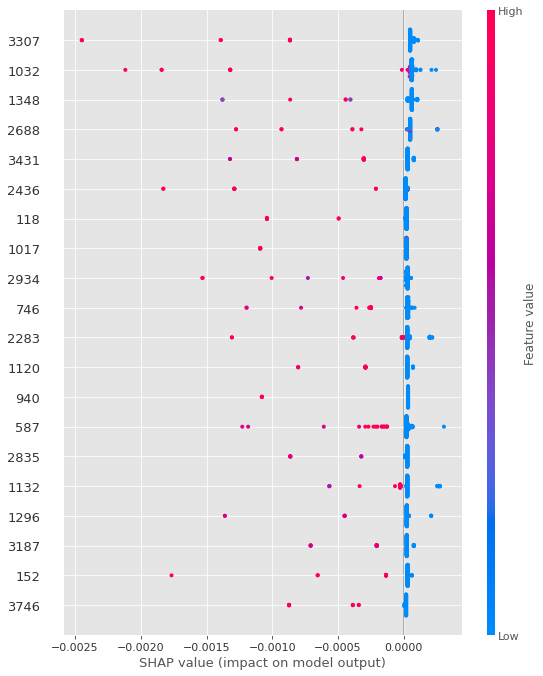

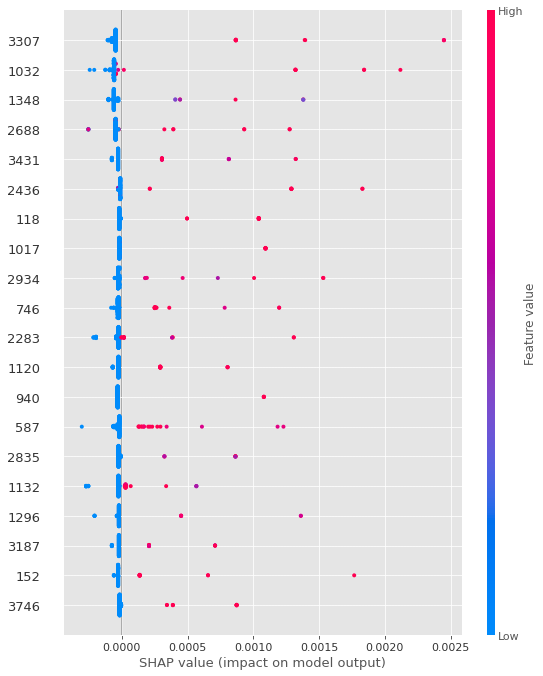

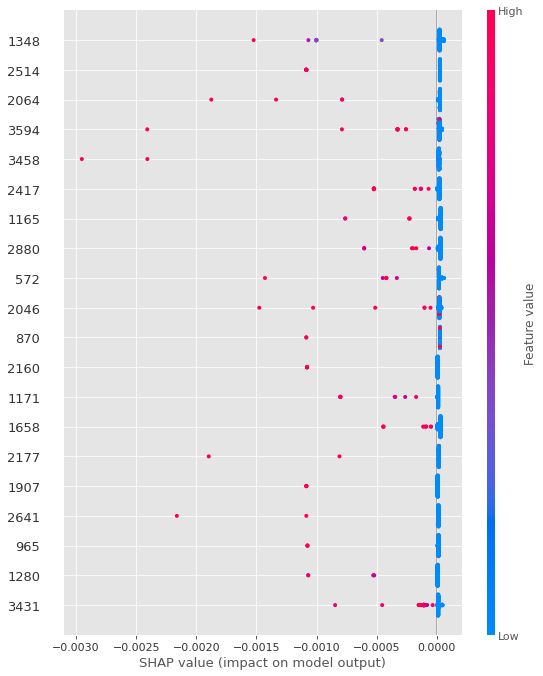

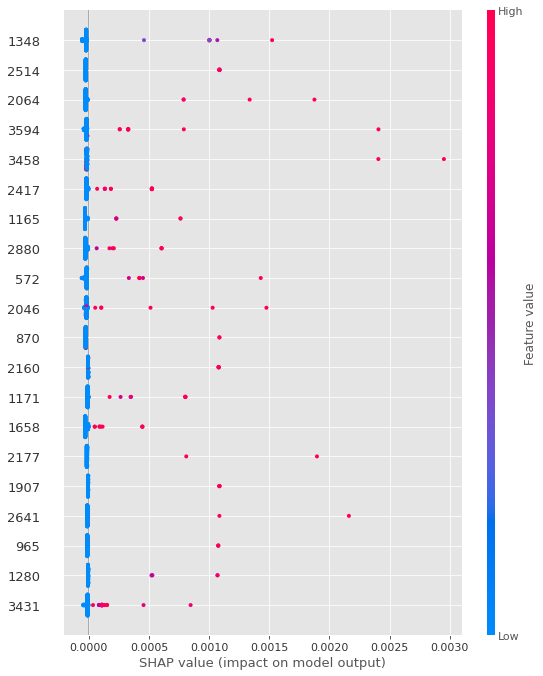

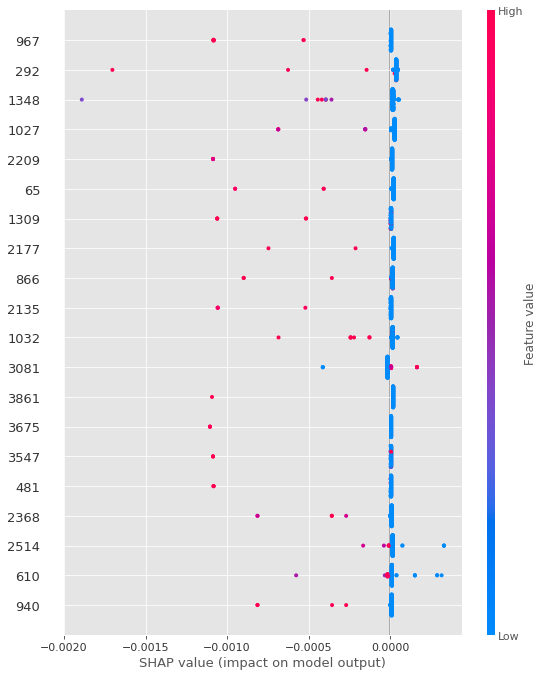

In [20]:
df_transposed.index = df_transposed.index.astype(str)
for i in range(5):
    shap.summary_plot(shap_values[:,:,i], df_transposed)